In [16]:
import pandas as pd
import numpy as np

In [17]:
# tách dữ liệu dựa trên thuộc tính
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right


### 0. Tính p : xác suất xuất hiện của từng lớp = số lượng xuất hiện của từng lớp/tổng dữ liệu

In [18]:
# proportion = count(class_value) / count(rows)

### 1. Tính gini index

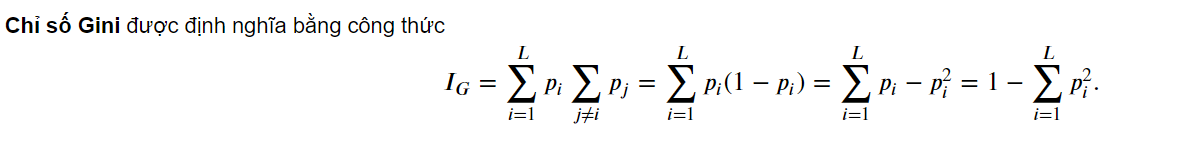

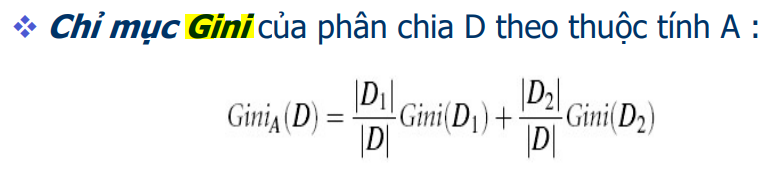

In [19]:
# Tính toán gini_index
def gini_index(groups, classes):
    # đếm số dòng trong data
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # để tránh trường hợp size = 0, nếu size=0 thì làm tiếp luôn
        if size == 0:
            continue
        score = 0.0
        # Tính tổng xác suất ở mỗi class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # Tính gini_index của phân chia D theo thuộc tính A 
        gini += (1.0 - score) * (size / n_instances)
    return gini

### 2. Chia dữ liệu

In [20]:
#chia dữ liệu thành các phần dựa và values, in ra để biết thêm chi tiết
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [21]:
# Lấy điểm dữ liệu tốt nhất để phân chia dựa vào gini index
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [22]:
# Lấy outcome dựa vào số lần xuất hiện, cái nào nhiều hơn thì lấy cái đó
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [23]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [24]:
# Tạo cây quyết định
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [25]:
from sklearn.model_selection import train_test_split
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

dataset = pd.read_csv(r"heart_failure_clinical_records_dataset.csv")
dt = [list(dataset.iloc[i]) for i in range(len(dataset))]

train, test = train_test_split(dt, test_size=0.3, random_state=42)
X_test = [row[:-1] for row in test]
y_test = [row[-1] for row in test]
tree =  build_tree(train, max_depth = 2, min_size = 1)
score = 0.0
for row_x, row_y in zip(X_test, y_test):
    prediction = predict(tree, row_x)
    if(prediction ==  row_y):
        score +=1
#     print('Expected=%d, Got=%d' % (row[-1], prediction))


In [26]:
print("Accuracy: ", score/len(test)*100)

Accuracy:  74.44444444444444


In [27]:
# In cây quyết định
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
tree = build_tree(dt, 2, 1)
print_tree(tree)

[X12 < 74.000]
 [X9 < 137.000]
  [1.0]
  [1.0]
 [X8 < 1.600]
  [0.0]
  [0.0]


AttributeError: 'dict' object has no attribute 'plot_tree'

In [ ]:
# sử dụng thư viện

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)

X_train = [row[:-1] for row in train]
y_train = [row[-1] for row in train]
clf = clf.fit(X_train, y_train)
pre = clf.predict(X_test)
score1 = 0.0
for y_pre, y_r in zip(pre, y_test):
    if(y_pre ==  y_r):
        score1 +=1
print("Accuracy: ", score1/len(test)*100)

Accuracy:  74.44444444444444


[Text(167.4, 181.2, 'X[11] <= 67.5\ngini = 0.405\nsamples = 209\nvalue = [150, 59]'),
 Text(83.7, 108.72, 'X[4] <= 72.5\ngini = 0.249\nsamples = 48\nvalue = [7, 41]'),
 Text(41.85, 36.23999999999998, 'gini = 0.223\nsamples = 47\nvalue = [6, 41]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(251.10000000000002, 108.72, 'X[7] <= 1.815\ngini = 0.199\nsamples = 161\nvalue = [143, 18]'),
 Text(209.25, 36.23999999999998, 'gini = 0.116\nsamples = 146\nvalue = [137, 9]'),
 Text(292.95, 36.23999999999998, 'gini = 0.48\nsamples = 15\nvalue = [6, 9]')]

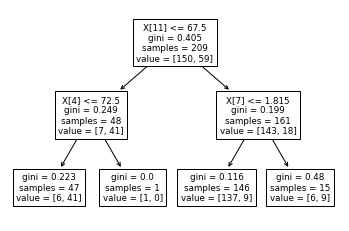

In [ ]:
tree.plot_tree(clf)